# Training model

## Install packages

In [1]:
import tensorflow as tf
import os

In [3]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "models/efficientnet/pipeline.config"
PATH_TO_CKPT = "training_output/"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)
#detection_model = tf.saved_model.load("inference_graph/mobilenet_trained_v1/saved_model")

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-229')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... 

2022-09-02 17:17:13.954717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done! Took 15.838856935501099 seconds


In [4]:
category_index = label_map_util.create_category_index_from_labelmap("training_files/label_map.pbtxt",
                                                                    use_display_name=True)

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
#warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def print_image(image_path):
    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

     # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                          for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.60,
            agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

In [6]:
%%time
image_path="test.jpg"
print_image(image_path)

Running inference for test.jpg... 

AttributeError: in user code:

    File "/var/folders/q3/lb_yq0b52dlfcvhwwbff6hv00000gn/T/ipykernel_11732/1539659107.py", line 27, in detect_fn  *
        image, shapes = detection_model.preprocess(image)

    AttributeError: '_UserObject' object has no attribute 'preprocess'


Running inference for test2.jpg... Done


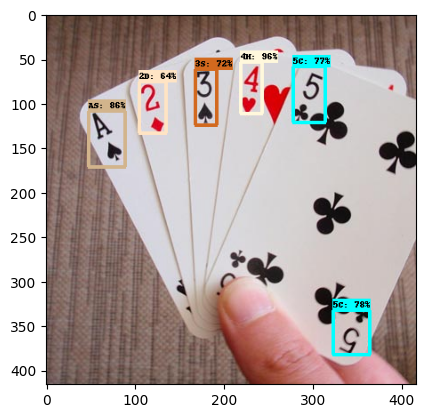

CPU times: user 1.44 s, sys: 597 ms, total: 2.04 s
Wall time: 426 ms


In [185]:
%%time
image_path="test2.jpg"
print_image(image_path)

Running inference for test5.jpg... Done


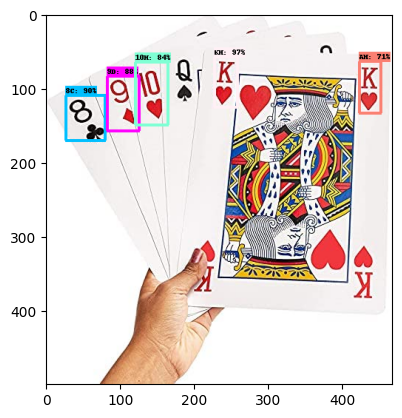

CPU times: user 12 s, sys: 709 ms, total: 12.7 s
Wall time: 11.2 s


In [186]:
%%time
image_path="test5.jpg"
print_image(image_path)

Running inference for test7.jpg... Done


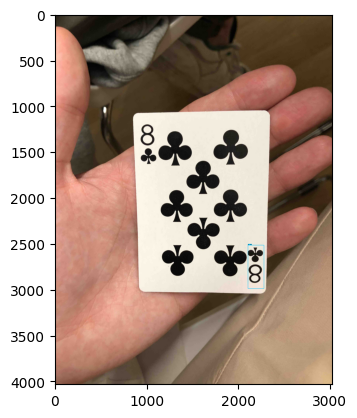

CPU times: user 14.3 s, sys: 1.24 s, total: 15.6 s
Wall time: 13.6 s


In [187]:
%%time
image_path="test7.jpg"
print_image(image_path)

Running inference for test6.jpg... Done


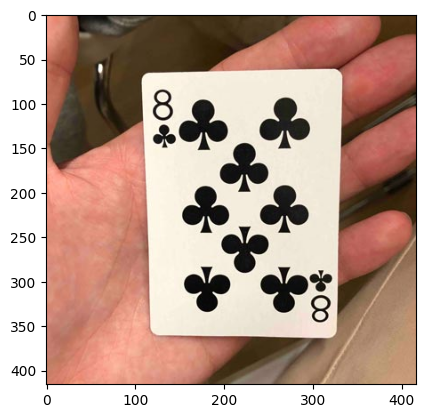

CPU times: user 1.4 s, sys: 602 ms, total: 2 s
Wall time: 417 ms


In [188]:
%%time
image_path="test6.jpg"
print_image(image_path)